## 3D Diagnostics

Working with 3D (lat, lon, depth) diagnostics is difficult as it puts a signficant load on memory usage ans storage. this notebook is for testing the optimization of compuations of 3D data, so they run efficiently on multi-core batch jobs. 

In [4]:
import numpy as np
import scipy as sc
import xarray as xr
#import dask.distributed
from dask.distributed import Client, performance_report
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize
#from dask import delayed
#from dask import compute
#from dask import persist
#import dask
#import distributed

import warnings
warnings.filterwarnings('ignore')

In [17]:
ppdir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

save_path="/gws/nopw/j04/snapdragon/hkhatri/Data_Drift/"

var = 'thetao'

r = 1 # ensemble number

year1, year2 = (1979, 1985)

In [3]:
client = Client(n_workers=4)

client

# client works with specific worker numbers (2-4 recommended)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37829/status,
Dashboard: http://127.0.0.1:37829/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39413,Workers: 4
Dashboard: http://127.0.0.1:37829/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:46543,Total threads: 1
Dashboard: http://127.0.0.1:44688/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:44257,


In [4]:
client.close()

In [19]:
%%time

ds = []

for year in range(year1-10, year2, 1):
            
    # Read data for each hindcast for every ensemble member
            
    var_path = "s" + str(year) +"-r" + str(r+1) + "i1p1f2/Omon/" + var + "/gn/latest/"
            
    d = xr.open_mfdataset(ppdir + var_path + "*.nc", decode_times=False)
    #d = xr.decode_cf(d) # required, so lat-lon coords are properly interpreted (does not work. makes lat lon function of time as well)
            
    # drop time coordinate as different time values create an issue in concat operation
    d = d.drop(['time', 'vertices_latitude', 'vertices_longitude', 'time_bnds'])
    if(var=='thetao'):
        d = d.drop('lev_bnds')
                
    d = d.isel(i=slice(749,1199), j = slice(699, 1149))

    ds.append(d)
            
# combine data for hindcasts
#ds = xr.concat(ds, dim='start_year', coords='minimal', data_vars='minimal')
#ds = ds.assign(start_year = np.arange(year1-10, year2, 1))

# with decode_cf = False takes about 4 mins for year1, year2 = (1979, 2010); however alt-lon become funciton of time
# with decode_times= False takes about 13 mins year1, year2 = (1979, 2010); keeps lat-lon as coordinate values

CPU times: user 42.6 s, sys: 7.06 s, total: 49.6 s
Wall time: 3min 29s


In [20]:
%time ds1 = xr.concat(ds, dim='start_year')
ds1 = ds1.assign(start_year = np.arange(year1-10, year2, 1))
ds1

CPU times: user 35.5 s, sys: 8.21 s, total: 43.7 s
Wall time: 2min 59s


<xarray.Dataset>
Dimensions:     (lev: 75, j: 450, i: 450, start_year: 16, time: 125)
Coordinates:
  * lev         (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j           (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i           (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude    (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude   (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
  * start_year  (start_year) int64 1969 1970 1971 1972 ... 1981 1982 1983 1984
Dimensions without coordinates: time
Data variables:
    thetao      (start_year, time, lev, j, i) float32 dask.array<chunksize=(1, 2, 75, 450, 450), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-12-08T09:03:50Z
    ...                     ...
    tracking_id:            hdl:21.14100/dbe78451-0159-4a34-9478-6d34aae5f42e
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r2i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [14]:
# takes about 2 min 1s
%time ds1 = xr.concat(ds, dim='start_year', coords='minimal')
ds1 = ds1.assign(start_year = np.arange(year1-10, year2, 1))

ds1

CPU times: user 30.5 s, sys: 7 s, total: 37.5 s
Wall time: 2min 5s


<xarray.Dataset>
Dimensions:     (lev: 75, j: 450, i: 450, start_year: 16, time: 125)
Coordinates:
  * lev         (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j           (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i           (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude    (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude   (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
  * start_year  (start_year) int64 1969 1970 1971 1972 ... 1981 1982 1983 1984
Dimensions without coordinates: time
Data variables:
    thetao      (start_year, time, lev, j, i) float32 dask.array<chunksize=(1, 2, 75, 450, 450), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-12-08T09:03:50Z
    ...                     ...
    tracking_id:            hdl:21.14100/dbe78451-0159-4a34-9478-6d34aae5f42e
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r2i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [1]:
# takes about 2 min 1s
%time ds1 = xr.concat(ds, dim='start_year', coords='minimal', data_vars='minimal')
ds1 = ds1.assign(start_year = np.arange(year1-10, year2, 1))

ds1

NameError: name 'xr' is not defined

NameError: name 'ds1' is not defined

In [23]:
ds2 = ds1 

In [24]:
ds1 = ds2.chunk({'start_year':1, 'time':12, 'lev':5})

ds1

<xarray.Dataset>
Dimensions:     (lev: 75, j: 450, i: 450, start_year: 16, time: 125)
Coordinates:
  * lev         (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j           (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i           (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude    (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
  * start_year  (start_year) int64 1969 1970 1971 1972 ... 1981 1982 1983 1984
Dimensions without coordinates: time
Data variables:
    thetao      (start_year, time, lev, j, i) float32 dask.array<chunksize=(1, 12, 5, 450, 450), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-12-08T09:03:50Z
    ...                     ...
    tracking_id:            hdl:21.14100/dbe78451-0159-4a34-9478-6d34aae5f42e
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r2i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [25]:
# Function for taking mean over hindcasts

def processDataset(ds1, year1, year2, lead_year):
    
    ds_save = []
    
    for year in range(year1, year2):
        
        # Extract data relavant start year and sum over all hindcasts
        ds3 = ds1.sel(start_year = year - lead_year).isel(time=slice(12*lead_year, np.minimum(12 + 12*lead_year, len(ds1['time']))))
        ds3 = ds3.copy() #map_blocks(np.copy)
        
        ds_save.append(ds3.drop('start_year'))
        
    ds_save = xr.concat(ds_save, dim='hindcast')
        
    return ds_save

In [26]:
lead_year = 0

ds_var = processDataset(ds1[var], year1, year2, lead_year)

ds_var

<xarray.DataArray 'thetao' (hindcast: 6, time: 12, lev: 75, j: 450, i: 450)>
dask.array<concatenate, shape=(6, 12, 75, 450, 450), dtype=float32, chunksize=(1, 12, 5, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: hindcast, time
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        mo: This variable is reported using a z* coordinate syste...
    units:          degC
    original_name:  mo: (variable_name: thetao)
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello

In [27]:
#ds_save = ds_save.mean('hindcast')

ds_save = ds_var.mean('hindcast')

#ds_save = xr.Dataset()
#ds_save[var] = ds_var

ds_save

<xarray.DataArray 'thetao' (time: 12, lev: 75, j: 450, i: 450)>
dask.array<mean_agg-aggregate, shape=(12, 75, 450, 450), dtype=float32, chunksize=(12, 5, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: time

In [28]:
with performance_report(filename="dask-report.html"):
    %time tmp = ds_save.compute()

ValueError: No global client found and no address provided

Compute step seems to work fine for 10-15 hindcasts but it fails when all hindcasts are included. Probably a memory issue.

In [11]:
# with chunks lev = 10 (1512 tasks -> 7056 tasks after chunking)
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time ds_save = ds_save.compute()
    
visualize([prof, rprof, cprof], filename='dask-optimization-lev-10.html')

CPU times: user 3min 13s, sys: 1min 57s, total: 5min 11s
Wall time: 3min 47s


Column(id='1273', ...)

In [16]:
# with chunks lev = 5 (1512 tasks -> 11907 tasks after chunking)
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time ds_save = ds_save.compute()
    
visualize([prof, rprof, cprof], filename='dask-optimization-lev-5.html')

CPU times: user 3min 20s, sys: 1min 52s, total: 5min 13s
Wall time: 3min 36s


Column(id='2699', ...)

In [21]:
# with chunks lev = 1 (1512 tasks -> 53487 tasks after chunking)
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time ds_save = ds_save.compute()
    
visualize([prof, rprof, cprof], filename='dask-optimization-lev-1.html')

CPU times: user 2min 56s, sys: 1min 1s, total: 3min 57s
Wall time: 3min 8s


Column(id='4125', ...)

In [ ]:
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time ds_save = ds_save.compute()
    
visualize([prof, rprof, cprof], filename='dask-map-blocks.html')

#### Chunking effect

There does not seem to be much advantage of having smaller chunks. However, memory usage and CPU time do decrease slightly.  

In [17]:
# 1979 - 2010 (decode_tiems = False)
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time ds_save = ds_save.compute()
    
    #ds_save.to_netcdf('test.nc')
    
visualize([prof, rprof, cprof], filename='dask-optimization-full-lev-1.html')

CPU times: user 9min 21s, sys: 3min 14s, total: 12min 35s
Wall time: 10min 20s


Column(id='1273', ...)

In [32]:
# 1979 - 2010 (decode_cf = False)
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time ds_save = ds_save.compute()
    
    #ds_save.to_netcdf('test.nc')
    
#visualize([prof, rprof, cprof], filename='dask-optimization-full-lev-1.html')

CPU times: user 8min 15s, sys: 2min 16s, total: 10min 32s
Wall time: 9min 39s


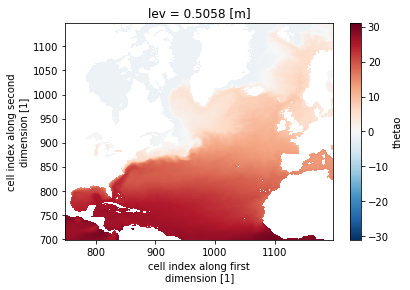

In [42]:
ds_save['thetao'].isel(time=3, lev=0).plot()

### Parallel write using xr.save_mfdataset

We use the method shown on [link](https://ncar.github.io/esds/posts/2020/writing-multiple-netcdf-files-in-parallel-with-xarray-and-dask/) to write data of different chunks into multiple files. 

In [12]:
import itertools

def split_by_chunks(dataset):
    chunk_slices = {}
    for dim, chunks in dataset.chunks.items():
        slices = []
        start = 0
        for chunk in chunks:
            if start >= dataset.sizes[dim]:
                break
            stop = start + chunk
            slices.append(slice(start, stop))
            start = stop
        chunk_slices[dim] = slices
    for slices in itertools.product(*chunk_slices.values()):
        selection = dict(zip(chunk_slices.keys(), slices))
        yield dataset[selection]

In [37]:
%time datasets = list(split_by_chunks(ds_save.persist()))

CPU times: user 1min 27s, sys: 54.4 s, total: 2min 22s
Wall time: 1min 19s


In [38]:
datasets[1]

<xarray.Dataset>
Dimensions:    (lev: 5, j: 450, i: 450, time: 12)
Coordinates:
  * lev        (lev) float64 6.543 8.093 9.823 11.77 13.99
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: time
Data variables:
    thetao     (time, lev, j, i) float32 dask.array<chunksize=(12, 5, 450, 450), meta=np.ndarray>

In [39]:
def create_filepath(ds, prefix='filename', root_path=".", i=0):
    filepath = f'{root_path}/{prefix}_chunk_{i}.nc'
    return filepath


#save_path = "./test_data_save"
save_path = "./test_data_save_persist"
filename = "Drift_" + var + "_r" + str(r+1)+ "_Lead_Year_" + str(int(lead_year+1))

#paths = [create_filepath(ds, prefix=filename, root_path=save_path) for ds in datasets]
paths = []
for i in range(0,len(datasets)):
    tmp = create_filepath(ds, prefix=filename, root_path=save_path, i=i+1)
    paths.append(tmp)

In [40]:
paths[0:5]

['./test_data_save_persist/Drift_thetao_r2_Lead_Year_1_chunk_1.nc',
 './test_data_save_persist/Drift_thetao_r2_Lead_Year_1_chunk_2.nc',
 './test_data_save_persist/Drift_thetao_r2_Lead_Year_1_chunk_3.nc',
 './test_data_save_persist/Drift_thetao_r2_Lead_Year_1_chunk_4.nc',
 './test_data_save_persist/Drift_thetao_r2_Lead_Year_1_chunk_5.nc']

In [31]:
# very slow without persist
%time xr.save_mfdataset(datasets=datasets, paths=paths)

CPU times: user 1h 19min 10s, sys: 15min 44s, total: 1h 34min 55s
Wall time: 1h 22min 49s


In [32]:
new_ds = xr.open_mfdataset(paths, combine='by_coords')
new_ds

<xarray.Dataset>
Dimensions:    (lev: 75, j: 450, i: 450, time: 12)
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: time
Data variables:
    thetao     (time, lev, j, i) float32 dask.array<chunksize=(12, 1, 450, 450), meta=np.ndarray>

In [41]:
# with persist and chunking in levels = 5
%time xr.save_mfdataset(datasets=datasets, paths=paths)

CPU times: user 311 ms, sys: 1.19 s, total: 1.5 s
Wall time: 2.28 s


In [42]:
new_ds = xr.open_mfdataset(paths, combine='by_coords')
new_ds

<xarray.Dataset>
Dimensions:    (lev: 75, j: 450, i: 450, time: 12)
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: time
Data variables:
    thetao     (time, lev, j, i) float32 dask.array<chunksize=(12, 5, 450, 450), meta=np.ndarray>

### ufunc approach

Probably not required. xarray takes care as there are not any numpy based functions.

In [58]:
# This is with xr.ufun

def ufunc_mean(ds, dim='hindcast'):
    
    tmp = ds.mean(axis=3)
    
    return tmp

ds2 = xr.apply_ufunc(ufunc_mean, ds_save, dask="parallelized", output_dtypes=[ds_save['thetao'].dtype])

ds2

<xarray.Dataset>
Dimensions:    (hindcast: 31, time: 12, lev: 75, j: 450, i: 450)
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: hindcast, time
Data variables:
    thetao     (hindcast, time, lev, j, i) float32 dask.array<chunksize=(1, 12, 1, 450, 450), meta=np.ndarray>

In [59]:
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time ds2 = ds2.compute()
    
#visualize([prof, rprof, cprof], filename='dask-optimization-full-ufunc-lev-1.html')

ValueError: axes don't match array

### Concat vs isel problem

Let's see if doing isel before or after contact operation makes any difference in memory consumption

In [9]:
ppdir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

var = 'thetao'

r = 1 # ensemble number

year1, year2 = (1980, 1985)

In [ ]:
client = Client(n_workers=4)
client

In [16]:
%%time

ds = []
ds1 = []

for year in range(year1, year2, 1):
            
    # Read data for each hindcast for every ensemble member
            
    var_path = "s" + str(year) +"-r" + str(r+1) + "i1p1f2/Omon/" + var + "/gn/latest/"
            
    d = xr.open_mfdataset(ppdir + var_path + "*.nc", parallel=True, decode_times=False)
    #almot no difference with parallel=True
            
    # drop time coordinate as different time values create an issue in concat operation
    d = d.drop(['time', 'vertices_latitude', 'vertices_longitude', 'time_bnds'])
    if(var=='thetao'):
        d = d.drop('lev_bnds')
                
    d = d.isel(i=slice(749,1199), j = slice(699, 1149))

    ds.append(d)
    
    d = d.isel(time=0)
    
    ds1.append(d)

CPU times: user 6.24 s, sys: 1.25 s, total: 7.48 s
Wall time: 26.5 s


In [17]:
%time ds_concat_isel = xr.concat(ds, dim='start_year')
ds_concat_isel

CPU times: user 855 ms, sys: 223 ms, total: 1.08 s
Wall time: 8.08 s


<xarray.Dataset>
Dimensions:    (lev: 75, j: 450, i: 450, start_year: 5, time: 125)
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: start_year, time
Data variables:
    thetao     (start_year, time, lev, j, i) float32 dask.array<chunksize=(1, 2, 75, 450, 450), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-12-31T20:15:30Z
    ...                     ...
    tracking_id:            hdl:21.14100/7ff4b0fa-745d-4fd5-9c72-dc828d195400
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r2i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [18]:
%time ds_isel_concat = xr.concat(ds1, dim='start_year')
ds_isel_concat

CPU times: user 604 ms, sys: 128 ms, total: 732 ms
Wall time: 4.02 s


<xarray.Dataset>
Dimensions:    (lev: 75, j: 450, i: 450, start_year: 5)
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: start_year
Data variables:
    thetao     (start_year, lev, j, i) float32 dask.array<chunksize=(1, 75, 450, 450), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-12-31T20:15:30Z
    ...                     ...
    tracking_id:            hdl:21.14100/7ff4b0fa-745d-4fd5-9c72-dc828d195400
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r2i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [25]:
tmp = ds_isel_concat.chunk({'start_year':-1, 'lev':10})
tmp

<xarray.Dataset>
Dimensions:    (lev: 75, j: 450, i: 450, start_year: 5)
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: start_year
Data variables:
    thetao     (start_year, lev, j, i) float32 dask.array<chunksize=(5, 10, 450, 450), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-12-31T20:15:30Z
    ...                     ...
    tracking_id:            hdl:21.14100/7ff4b0fa-745d-4fd5-9c72-dc828d195400
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r2i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [19]:
with performance_report(filename="time-concat-isel.html"):
    %time tmp1 = ds_concat_isel['thetao'].isel(time=0).mean('start_year').compute()

CPU times: user 843 ms, sys: 345 ms, total: 1.19 s
Wall time: 18.4 s


In [20]:
with performance_report(filename="time-isel-concat.html"):
    %time tmp2 = ds_isel_concat['thetao'].mean('start_year').compute()

CPU times: user 657 ms, sys: 291 ms, total: 949 ms
Wall time: 15.6 s


In [23]:
with performance_report(filename="time-concat-isel-copy.html"):
    tmp1 = ds_concat_isel['thetao'].isel(time=0).copy()
    %time tmp1 = tmp1.mean('start_year').persist()

CPU times: user 15.1 ms, sys: 1.97 ms, total: 17.1 ms
Wall time: 17 ms


In [13]:
tmp1 = ds_isel_concat['thetao']
print(tmp1)
tmp1 = tmp1[::1]
print(tmp1)

<xarray.DataArray 'thetao' (start_year: 5, lev: 75, j: 450, i: 450)>
dask.array<concatenate, shape=(5, 75, 450, 450), dtype=float32, chunksize=(1, 75, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: start_year
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        mo: This variable is reported using a z* coordinate syste...
    units:          degC
    original_name:  mo: (variable_name: thetao)
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello


In [5]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39296,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:41736,Total threads: 1
Dashboard: http://127.0.0.1:37506/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:40947,


In [6]:
ds = xr.open_mfdataset(ppdir + 's1974-r1i1p1f2/Omon/thetao/gn/v20200417/' + 
                       'thetao_Omon_HadGEM3-GC31-MM_dcppA-hindcast_s1974-r1i1p1f2_gn_197501-197512.nc')

In [7]:
ds

<xarray.Dataset>
Dimensions:             (time: 12, bnds: 2, lev: 75, j: 1205, i: 1440,
                         vertices: 4)
Coordinates:
  * time                (time) object 1975-01-16 00:00:00 ... 1975-12-16 00:0...
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j                   (j) int32 0 1 2 3 4 5 ... 1199 1200 1201 1202 1203 1204
  * i                   (i) int32 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
    latitude            (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(1205, 1440, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(1205, 1440, 4), meta=np.ndarray>
    thetao              (time, lev, j, i) float32 dask.array<chunksize=(12, 75, 1205, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-12-11T00:12:46Z
    ...                     ...
    tracking_id:            hdl:21.14100/da44c917-0b66-4a3c-ab9c-b0fd7e118b5e
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [8]:
ds.thetao

<xarray.DataArray 'thetao' (time: 12, lev: 75, j: 1205, i: 1440)>
dask.array<open_dataset-56e215cdda7983f9bcd197885710b85dthetao, shape=(12, 75, 1205, 1440), dtype=float32, chunksize=(12, 75, 1205, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1975-01-16 00:00:00 ... 1975-12-16 00:00:00
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 ... 1198 1199 1200 1201 1202 1203 1204
  * i          (i) int32 0 1 2 3 4 5 6 7 ... 1433 1434 1435 1436 1437 1438 1439
    latitude   (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        mo: This variable is reported using a z* coordinate syste...
    units:          degC
    original_name:  mo: (variable_name: thetao)
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello